# Test: Do the Buzzard errorbars scale with sqrt(N)?

In [5]:
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo, z_at_value
import coop_post_processing as cpp
import coop_setup_funcs as csf
import healpy as hp
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rcParams['font.size']=14
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['text.usetex']=False
import stats as st
import sys

In [6]:
obspath  = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/"
buzzpath = "/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/"

# Define the distance bins
dbins = [[893, 1393], [1493, 1993], [2093, 2593], [2693,3193]]
zbins = ['0pt20_0pt36', '0pt36_0pt53', '0pt53_0pt72', '0pt72_0pt94'] # the z bins for number density maps
obspath  = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/"
mask =  "/mnt/raid-cita/mlokken/data/masks/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask_hpx_4096.fits"
nu_e_cuts = True
if nu_e_cuts:
    pt_selection_str = 'nugt2_egtpt3_'
else:
    pt_selection_str = ''
nreg = 24
acty_mapstr = f'ilc_SZ_yy_4096_hpx'
buzzy_mapstr = f'ymap_buzzard_fid_hpx'
buzzy_mapstr_break = 'ymap_buzzard_break_bbps_car_1p6arcmin_cutoff4_alphabreak0.972_4096_hpx'



In [55]:
def retrieve_stack_info(path, mapstr, pt_selection_str, cl_dbin, cutmin=20, pct=75, orient_mode='maglim', xyup=True, binsize=7.5, crop_center=2.5, scale=None, make_delta=False, remove_r30=False, nreg=24, samplesize=None):
    if xyup:
        xyupstr = '_orientXYUP'
    else:
        xyupstr = ''
    
    cl_dlow, cl_dhi = cl_dbin[0], cl_dbin[1] # extent of the clusters
    
    g_dlow   = cl_dlow-50 # extent of the galaxies
    g_dhi    = cl_dhi+50
    zlow   = z_at_value(cosmo.comoving_distance, cl_dlow*u.Mpc)
    zhi    = z_at_value(cosmo.comoving_distance, cl_dhi*u.Mpc)
    
    file = path + f"{mapstr}_redmapper_lambdagt{cutmin}_combined_{cl_dlow}_{cl_dhi}Mpc_{pt_selection_str}20pt0{xyupstr}_{pct}pct_{orient_mode}_{g_dlow}_{g_dhi}Mpc_{nreg}reg_m0to5_profiles.pkl"
    print(f"retrieving data from {file}")
    print(file)
    stack_info = np.load(file, allow_pickle=True)
    # rearrange shape of profs to be compatible with Stack_object
    
    if samplesize == None:
        choice = np.arange(len(stack_info['prof']))
    else:    
        choice = np.random.choice(len(stack_info['prof']), size=samplesize, replace=False)
    profs = np.transpose(np.asarray(stack_info['prof'])[choice], axes=[2,0,1])
    if crop_center is not None:
        rmax = len(profs[0,0,:])
        r_in_mpc = 40/rmax*np.arange(rmax)
        idx_crop = np.where(np.abs(r_in_mpc-crop_center) == np.min(np.abs(r_in_mpc-crop_center)))[0][0]
        # cut off profiles up to 2.5 Mpc
        profs = profs[:,:,idx_crop:]
    
    if scale is not None:
        profs *= scale
    
    
    stack_obj = cpp.Stack_object(img_splits=np.asarray(stack_info['stacks'])[choice], profile_splits=profs, Npks_splits=np.asarray(stack_info['npks_list'])[choice], rad_in_Mpc=40)
    if crop_center is not None:
        # reset r of stack_obj to account for 2.5 Mpc cut
        stack_obj.r = stack_obj.r[idx_crop:]
    
    if make_delta:
        # find the average matter density over the extent of the redshift range
        rholist = []
        # plt.figure(figsize=(10,10))
        for chi in np.linspace(cl_dlow, cl_dhi,100):
            chibinsize = (cl_dhi-cl_dlow)/100
            zmid = z_at_value(cosmo.comoving_distance, (chi+chibinsize)/2*u.Mpc)
            rho_avg_chi = cosmo.Om(z=zmid)* cosmo.critical_density0.to(u.Msun/u.Mpc**3)
            # multiply it by the bin size to get the average surface mass density in the bin
            rho_avg_bin = rho_avg_chi * chibinsize * u.Mpc
            rholist.append(rho_avg_bin.value)
        avg_matter = np.average(rholist)
        print("average rho in this bin", avg_matter)
        stack_obj.profile_splits[:,:,:] /= avg_matter
        # convert 2D delta to 3D delta by estimating length of object along line of sight
        est_los = 10 # Mpc
        stack_obj.profile_splits[:,:,:] /= est_los
    if remove_r30:
        idx_r30 = np.where(np.abs(stack_obj.r-30) == np.min(np.abs(stack_obj.r-30)))[0][0]
        for r in range(stack_obj.profile_splits.shape[1]):
            avg_r30 = np.average(stack_obj.profile_splits[0,r,:][idx_r30:])
            stack_obj.profile_splits[0,r,:] -= avg_r30
        
        
    stack_obj.set_average_profiles()
    stack_obj.bin_and_get_stats(binsize) #Mpc
    return stack_obj, (zlow, zhi)



retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_843_1443Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_843_1443Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_843_1443Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_843_1443Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_1393Mpc_nu

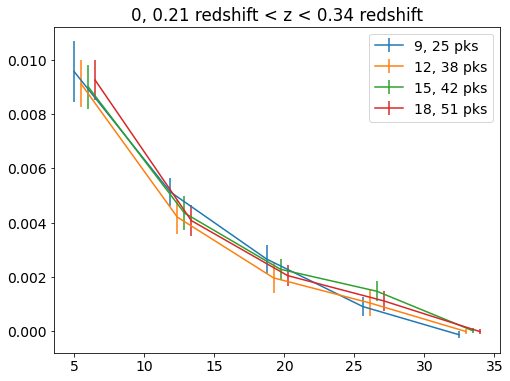

If Poisson, error ratio between 18 and 15 samples should be 0.9074852129730301, it is 0.9359121534525543
If Poisson, error ratio between 18 and 12 samples should be 0.8631906158060839, it is 0.8154859970943011
If Poisson, error ratio between 18 and 9 samples should be 0.7001400420140049, it is 0.8204209791792184
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_843_1443Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_843_1443Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_843_1443Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stackin

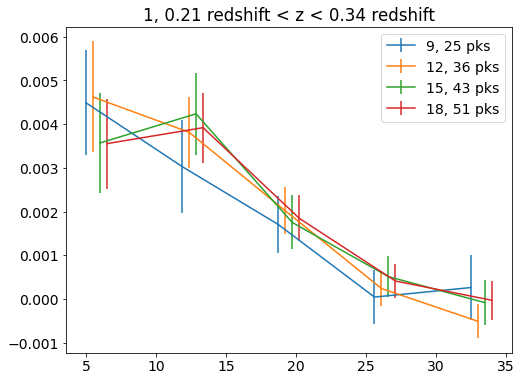

If Poisson, error ratio between 18 and 15 samples should be 0.9182250567818114, it is 0.8667539377404824
If Poisson, error ratio between 18 and 12 samples should be 0.8401680504168059, it is 0.9435847286925879
If Poisson, error ratio between 18 and 9 samples should be 0.7001400420140049, it is 0.7474941601582407
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_843_1443Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_843_1443Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_843_1443Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stackin

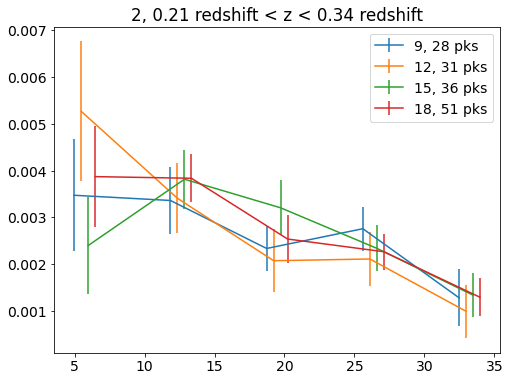

If Poisson, error ratio between 18 and 15 samples should be 0.8401680504168059, it is 0.9021774777189036
If Poisson, error ratio between 18 and 12 samples should be 0.7796429549831781, it is 0.7135052341075617
If Poisson, error ratio between 18 and 9 samples should be 0.7409585736349484, it is 0.8324624483903109
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_843_1443Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_843_1443Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_843_1443Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stackin

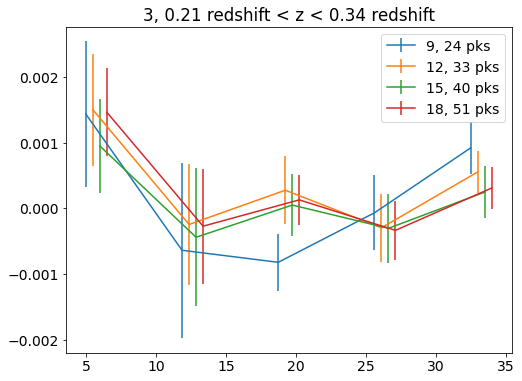

If Poisson, error ratio between 18 and 15 samples should be 0.8856148855400953, it is 0.8573078263367035
If Poisson, error ratio between 18 and 12 samples should be 0.8043996665398437, it is 0.8642443834856762
If Poisson, error ratio between 18 and 9 samples should be 0.6859943405700354, it is 0.7034697347258112
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_843_1443Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_843_1443Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_843_1443Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stackin

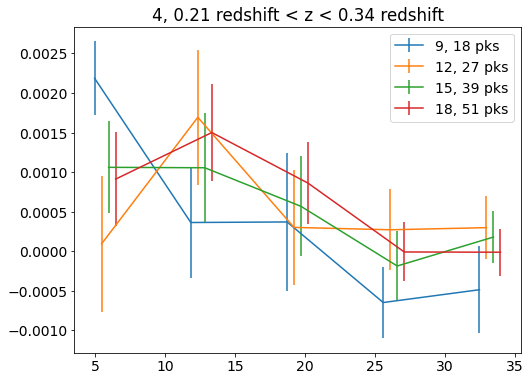

If Poisson, error ratio between 18 and 15 samples should be 0.8744746321952062, it is 0.9013362651295711
If Poisson, error ratio between 18 and 12 samples should be 0.7276068751089989, it is 0.7172157544350003
If Poisson, error ratio between 18 and 9 samples should be 0.5940885257860046, it is 0.7884250445701052
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt36_0pt53_redmapper_lambdagt20_combined_1493_1993Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_1443_2043Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt36_0pt53_redmapper_lambdagt20_combined_1493_1993Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_1443_2043Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt36_0pt53_redmapper_lambdagt20_combined_1493_1993Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_1443_2043Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/s

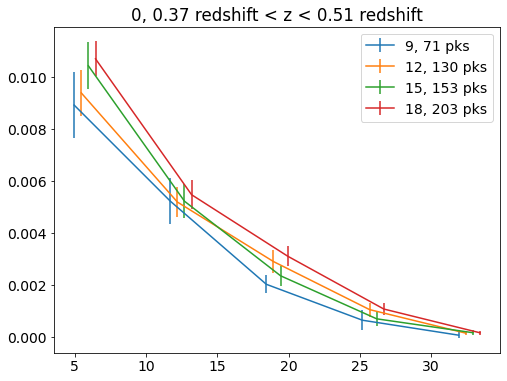

If Poisson, error ratio between 18 and 15 samples should be 0.8681558508014492, it is 0.824089688510413
If Poisson, error ratio between 18 and 12 samples should be 0.8002462675139139, it is 0.8500505190781499
If Poisson, error ratio between 18 and 9 samples should be 0.5913997756013109, it is 0.645187493770957
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt36_0pt53_redmapper_lambdagt20_combined_1493_1993Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_1443_2043Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt36_0pt53_redmapper_lambdagt20_combined_1493_1993Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_1443_2043Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt36_0pt53_redmapper_lambdagt20_combined_1493_1993Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_1443_2043Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/sta

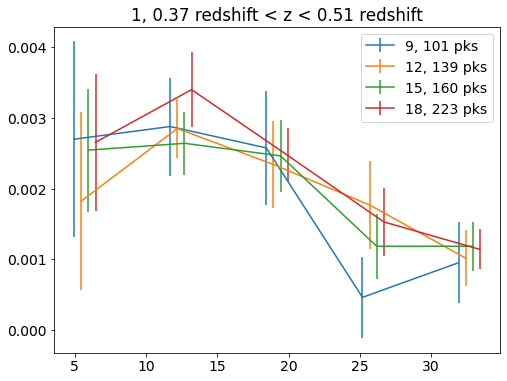

If Poisson, error ratio between 18 and 15 samples should be 0.8470470997752534, it is 1.005128502005021
If Poisson, error ratio between 18 and 12 samples should be 0.7895051523899158, it is 0.797963073215737
If Poisson, error ratio between 18 and 9 samples should be 0.6729894488075411, it is 0.6570434412667266
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt36_0pt53_redmapper_lambdagt20_combined_1493_1993Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_1443_2043Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt36_0pt53_redmapper_lambdagt20_combined_1493_1993Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_1443_2043Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt36_0pt53_redmapper_lambdagt20_combined_1493_1993Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_1443_2043Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/sta

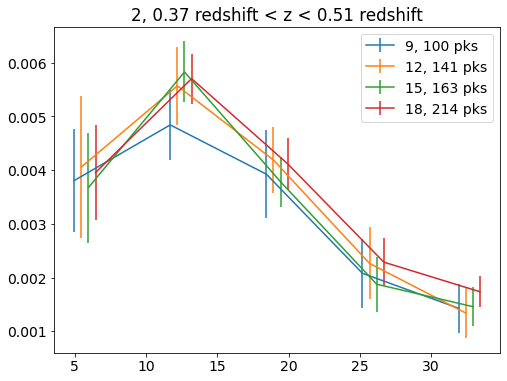

If Poisson, error ratio between 18 and 15 samples should be 0.8727440879150395, it is 0.870418971475483
If Poisson, error ratio between 18 and 12 samples should be 0.8117133143375789, it is 0.6753281959551224
If Poisson, error ratio between 18 and 9 samples should be 0.6835859270246633, it is 0.7261066566281076
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt36_0pt53_redmapper_lambdagt20_combined_1493_1993Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_1443_2043Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt36_0pt53_redmapper_lambdagt20_combined_1493_1993Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_1443_2043Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt36_0pt53_redmapper_lambdagt20_combined_1493_1993Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_1443_2043Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/st

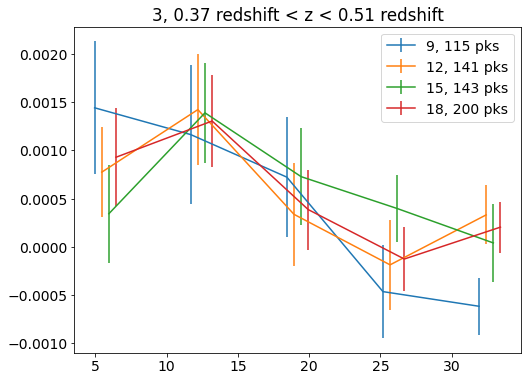

If Poisson, error ratio between 18 and 15 samples should be 0.8455767262643882, it is 0.874923589036865
If Poisson, error ratio between 18 and 12 samples should be 0.8396427811873333, it is 0.8520177552857682
If Poisson, error ratio between 18 and 9 samples should be 0.758287544405155, it is 0.7133716027452844
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt36_0pt53_redmapper_lambdagt20_combined_1493_1993Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_1443_2043Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt36_0pt53_redmapper_lambdagt20_combined_1493_1993Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_1443_2043Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt36_0pt53_redmapper_lambdagt20_combined_1493_1993Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_1443_2043Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/sta

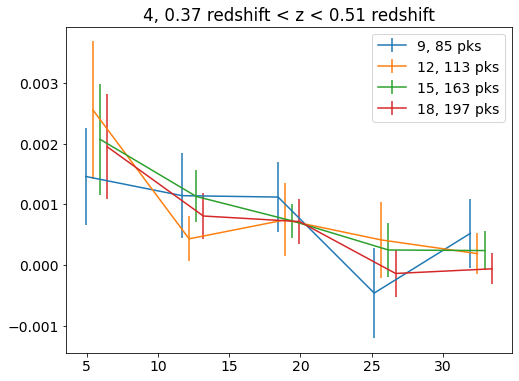

If Poisson, error ratio between 18 and 15 samples should be 0.9096214418716669, it is 0.9490588486149553
If Poisson, error ratio between 18 and 12 samples should be 0.7573665300986739, it is 0.7361670372297816
If Poisson, error ratio between 18 and 9 samples should be 0.6568653448145017, it is 0.6681777559527606
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt53_0pt72_redmapper_lambdagt20_combined_2093_2593Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2043_2643Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt53_0pt72_redmapper_lambdagt20_combined_2093_2593Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2043_2643Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt53_0pt72_redmapper_lambdagt20_combined_2093_2593Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2043_2643Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/s

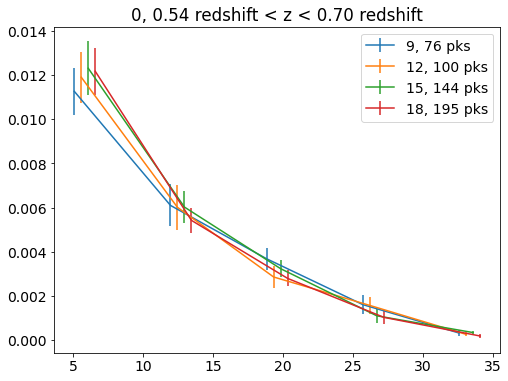

If Poisson, error ratio between 18 and 15 samples should be 0.8593378488473195, it is 0.8715947106922346
If Poisson, error ratio between 18 and 12 samples should be 0.7161148740394329, it is 0.7519656750891721
If Poisson, error ratio between 18 and 9 samples should be 0.6242944735808493, it is 0.7835435004608544
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt53_0pt72_redmapper_lambdagt20_combined_2093_2593Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2043_2643Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt53_0pt72_redmapper_lambdagt20_combined_2093_2593Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2043_2643Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt53_0pt72_redmapper_lambdagt20_combined_2093_2593Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2043_2643Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/s

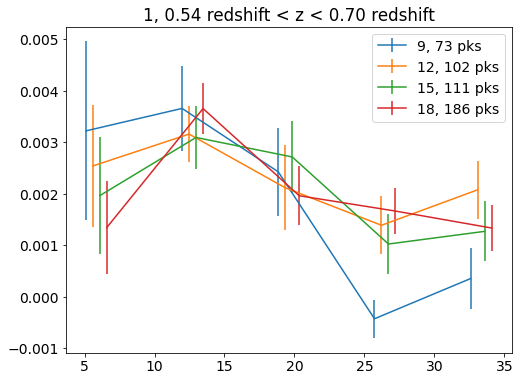

If Poisson, error ratio between 18 and 15 samples should be 0.772511613859874, it is 0.7916809186378393
If Poisson, error ratio between 18 and 12 samples should be 0.7405316311773545, it is 0.7754571934790644
If Poisson, error ratio between 18 and 9 samples should be 0.6264767499912266, it is 0.6517246909174085
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt53_0pt72_redmapper_lambdagt20_combined_2093_2593Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2043_2643Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt53_0pt72_redmapper_lambdagt20_combined_2093_2593Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2043_2643Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt53_0pt72_redmapper_lambdagt20_combined_2093_2593Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2043_2643Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/st

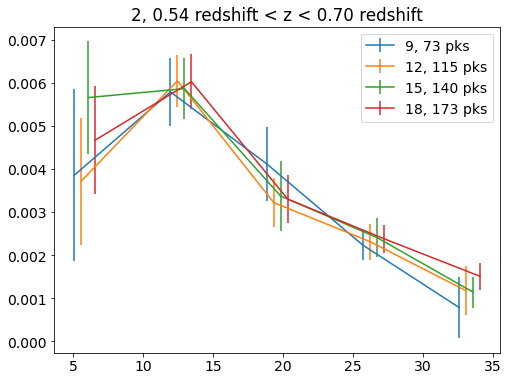

If Poisson, error ratio between 18 and 15 samples should be 0.8995824336397943, it is 0.84973935974297
If Poisson, error ratio between 18 and 12 samples should be 0.8153158188046296, it is 0.8502551522414592
If Poisson, error ratio between 18 and 9 samples should be 0.6495885758840554, it is 0.6590063671439065
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt53_0pt72_redmapper_lambdagt20_combined_2093_2593Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2043_2643Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt53_0pt72_redmapper_lambdagt20_combined_2093_2593Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2043_2643Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt53_0pt72_redmapper_lambdagt20_combined_2093_2593Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2043_2643Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/sta

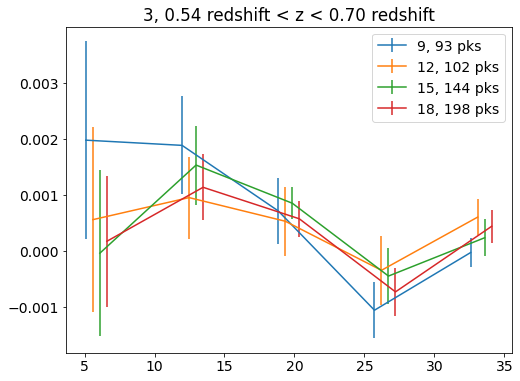

If Poisson, error ratio between 18 and 15 samples should be 0.8528028654224418, it is 0.8496372934764869
If Poisson, error ratio between 18 and 12 samples should be 0.7177405625652734, it is 0.7100027837452736
If Poisson, error ratio between 18 and 9 samples should be 0.6853444168423419, it is 0.7040982487971834
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt53_0pt72_redmapper_lambdagt20_combined_2093_2593Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2043_2643Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt53_0pt72_redmapper_lambdagt20_combined_2093_2593Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2043_2643Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt53_0pt72_redmapper_lambdagt20_combined_2093_2593Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2043_2643Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/s

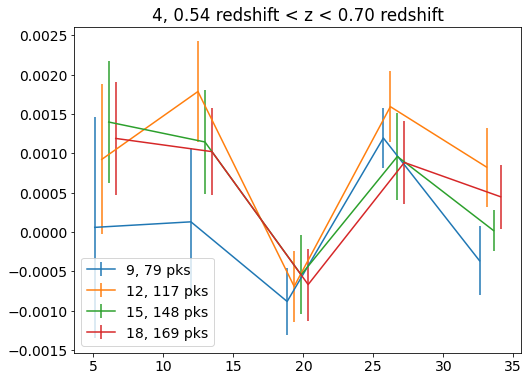

If Poisson, error ratio between 18 and 15 samples should be 0.93580962004588, it is 0.9668079613631623
If Poisson, error ratio between 18 and 12 samples should be 0.8320502943378437, it is 0.8915736251585382
If Poisson, error ratio between 18 and 9 samples should be 0.6837072628704299, it is 0.7390615016004173
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt72_0pt94_redmapper_lambdagt20_combined_2693_3193Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2643_3243Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt72_0pt94_redmapper_lambdagt20_combined_2693_3193Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2643_3243Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt72_0pt94_redmapper_lambdagt20_combined_2693_3193Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2643_3243Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/sta

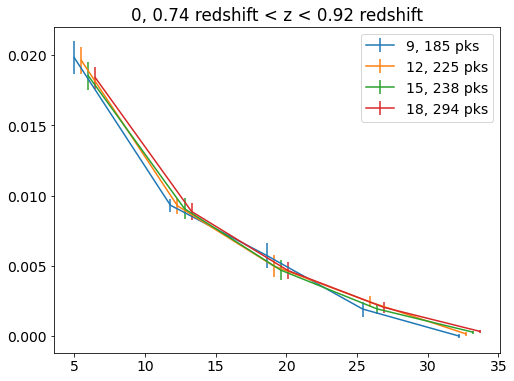

If Poisson, error ratio between 18 and 15 samples should be 0.8997354108424374, it is 0.860707879939713
If Poisson, error ratio between 18 and 12 samples should be 0.8748177652797064, it is 0.8885493865633612
If Poisson, error ratio between 18 and 9 samples should be 0.7932538689979849, it is 0.8015491791031372
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt72_0pt94_redmapper_lambdagt20_combined_2693_3193Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2643_3243Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt72_0pt94_redmapper_lambdagt20_combined_2693_3193Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2643_3243Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt72_0pt94_redmapper_lambdagt20_combined_2693_3193Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2643_3243Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/st

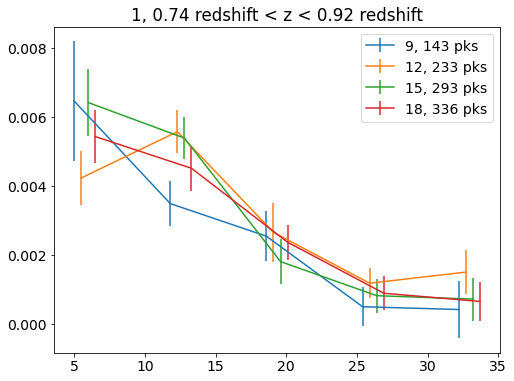

If Poisson, error ratio between 18 and 15 samples should be 0.9338221509065897, it is 0.889792523465069
If Poisson, error ratio between 18 and 12 samples should be 0.832737882501079, it is 0.8911048523509076
If Poisson, error ratio between 18 and 9 samples should be 0.6523766075628694, it is 0.664393677564959
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt72_0pt94_redmapper_lambdagt20_combined_2693_3193Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2643_3243Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt72_0pt94_redmapper_lambdagt20_combined_2693_3193Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2643_3243Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt72_0pt94_redmapper_lambdagt20_combined_2693_3193Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2643_3243Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stac

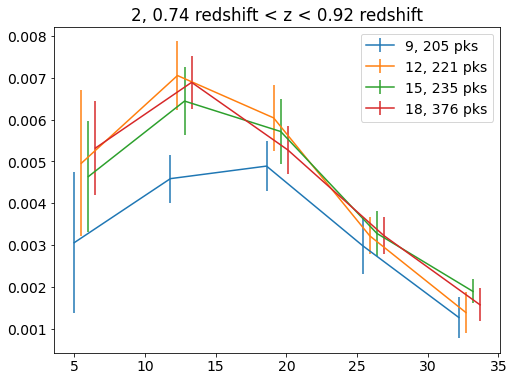

If Poisson, error ratio between 18 and 15 samples should be 0.7905694150420949, it is 0.8408429871987281
If Poisson, error ratio between 18 and 12 samples should be 0.7666589577164076, it is 0.7378617283897304
If Poisson, error ratio between 18 and 9 samples should be 0.738385242239745, it is 0.787985597061368
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt72_0pt94_redmapper_lambdagt20_combined_2693_3193Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2643_3243Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt72_0pt94_redmapper_lambdagt20_combined_2693_3193Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2643_3243Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt72_0pt94_redmapper_lambdagt20_combined_2693_3193Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2643_3243Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/sta

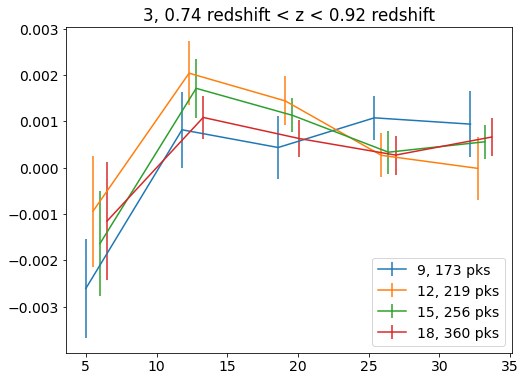

If Poisson, error ratio between 18 and 15 samples should be 0.8432740427115678, it is 1.0026633174900181
If Poisson, error ratio between 18 and 12 samples should be 0.779957263786506, it is 0.8322505060087448
If Poisson, error ratio between 18 and 9 samples should be 0.693221144769514, it is 0.7898383148594831
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt72_0pt94_redmapper_lambdagt20_combined_2693_3193Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2643_3243Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt72_0pt94_redmapper_lambdagt20_combined_2693_3193Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2643_3243Mpc_24reg_m0to5_profiles.pkl
retrieving data from /mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/Buzzard_maglim_z_0pt72_0pt94_redmapper_lambdagt20_combined_2693_3193Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_2643_3243Mpc_24reg_m0to5_profiles.pkl
/mnt/scratch-lustre/mlokken/sta

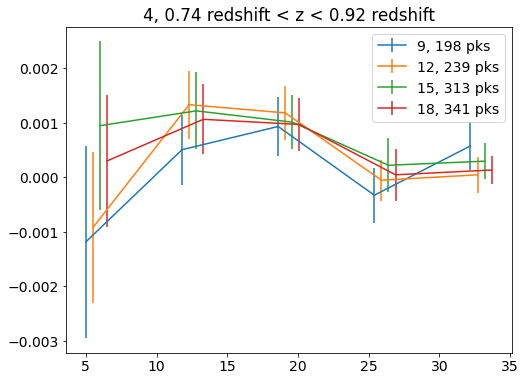

If Poisson, error ratio between 18 and 15 samples should be 0.9580650098244134, it is 0.8620805865903025
If Poisson, error ratio between 18 and 12 samples should be 0.8371856218282147, it is 0.9575473555472181
If Poisson, error ratio between 18 and 9 samples should be 0.762000762001143, it is 0.7921707858987559


<Figure size 576x432 with 0 Axes>

In [58]:
for col, dbin in enumerate(dbins):
    buzzng_mapstr = f'Buzzard_maglim_z_{zbins[col]}'
    
    for m in range(5):
        samplesize=9
        buzz_obj, (zlow,zhi) = retrieve_stack_info(buzzpath, buzzng_mapstr, pt_selection_str, dbin, remove_r30=True, samplesize=samplesize)
        plt.errorbar(buzz_obj.r_binned-1, buzz_obj.avg_profiles_binned[m], buzz_obj.errors_binned[m], label=f'{samplesize}, {buzz_obj.Npks_tot} pks')
        avg_9samples = np.average(buzz_obj.errors_binned[m])
        Npks_tot_9 = buzz_obj.Npks_tot
        samplesize=12
        buzz_obj, (zlow,zhi) = retrieve_stack_info(buzzpath, buzzng_mapstr, pt_selection_str, dbin, remove_r30=True, samplesize=samplesize)
        plt.errorbar(buzz_obj.r_binned-.5, buzz_obj.avg_profiles_binned[m], buzz_obj.errors_binned[m], label=f'{samplesize}, {buzz_obj.Npks_tot} pks')
        avg_12samples = np.average(buzz_obj.errors_binned[m])
        Npks_tot_12 = buzz_obj.Npks_tot
        samplesize=15
        buzz_obj, (zlow,zhi) = retrieve_stack_info(buzzpath, buzzng_mapstr, pt_selection_str, dbin, remove_r30=True, samplesize=samplesize)
        plt.errorbar(buzz_obj.r_binned, buzz_obj.avg_profiles_binned[m], buzz_obj.errors_binned[m], label=f'{samplesize}, {buzz_obj.Npks_tot} pks')
        avg_15samples = np.average(buzz_obj.errors_binned[m])
        Npks_tot_15 = buzz_obj.Npks_tot
        samplesize=18
        buzz_obj, (zlow,zhi) = retrieve_stack_info(buzzpath, buzzng_mapstr, pt_selection_str, dbin, remove_r30=True, samplesize=samplesize)
        avg_18samples = np.average(buzz_obj.errors_binned[m])
        Npks_tot_18 = buzz_obj.Npks_tot
        plt.errorbar(buzz_obj.r_binned+.5, buzz_obj.avg_profiles_binned[m], buzz_obj.errors_binned[m], label=f'{samplesize}, {buzz_obj.Npks_tot} pks')
        plt.title(f"{m}, {zlow:.2f} < z < {zhi:.2f}")
        
        plt.legend()
        plt.show()
        plt.clf()
        print(f"If Poisson, error ratio between 18 and 15 samples should be {np.sqrt(Npks_tot_15/Npks_tot_18)}, it is {avg_18samples/avg_15samples}")
        print(f"If Poisson, error ratio between 18 and 12 samples should be {np.sqrt(Npks_tot_12/Npks_tot_18)}, it is {avg_18samples/avg_12samples}")
        print(f"If Poisson, error ratio between 18 and 9 samples should be {np.sqrt(Npks_tot_9/Npks_tot_18)}, it is {avg_18samples/avg_9samples}")